# The HR diagram

In [1]:
import numpy as np
import pylab as plt
import scipy.stats
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from astroML.datasets import sdss_corrected_spectra
from astroML.utils import pickle_results
from sklearn.preprocessing import StandardScaler
from astroML.utils import split_samples
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import ssl
import urllib.request

plt.style.use('seaborn-v0_8-deep')
plt.rc('text', usetex=True)  
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Download and explore the dataset

In [2]:
# Disabilita la verifica del certificato SSL
ssl._create_default_https_context = ssl._create_unverified_context

# Scarica il file
urllib.request.urlretrieve("https://raw.githubusercontent.com/nshaud/ml_for_astro/main/stars.csv", "stars.csv")

('stars.csv', <http.client.HTTPMessage at 0x300d6b3e0>)

In [3]:
df_stars = pd.read_csv("stars.csv")

In [4]:
df_stars

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,Brown Dwarf,Red,M
1,3042,0.000500,0.1542,16.60,Brown Dwarf,Red,M
2,2600,0.000300,0.1020,18.70,Brown Dwarf,Red,M
3,2800,0.000200,0.1600,16.65,Brown Dwarf,Red,M
4,1939,0.000138,0.1030,20.06,Brown Dwarf,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Hypergiant,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Hypergiant,Blue,O
237,8829,537493.000000,1423.0000,-10.73,Hypergiant,White,A
238,9235,404940.000000,1112.0000,-11.23,Hypergiant,White,A


In [5]:
le = LabelEncoder()
# Assign unique integers from 0 to 6 to each star type
df_stars['Star type'] = le.fit_transform(df_stars['Star type'])
labels = le.inverse_transform(df_stars['Star type'])
class_names = le.classes_
#print(df_stars['Star type'])
print(class_names)

['Brown Dwarf' 'Hypergiant' 'Main Sequence' 'Red Dwarf' 'Supergiant'
 'White Dwarf']


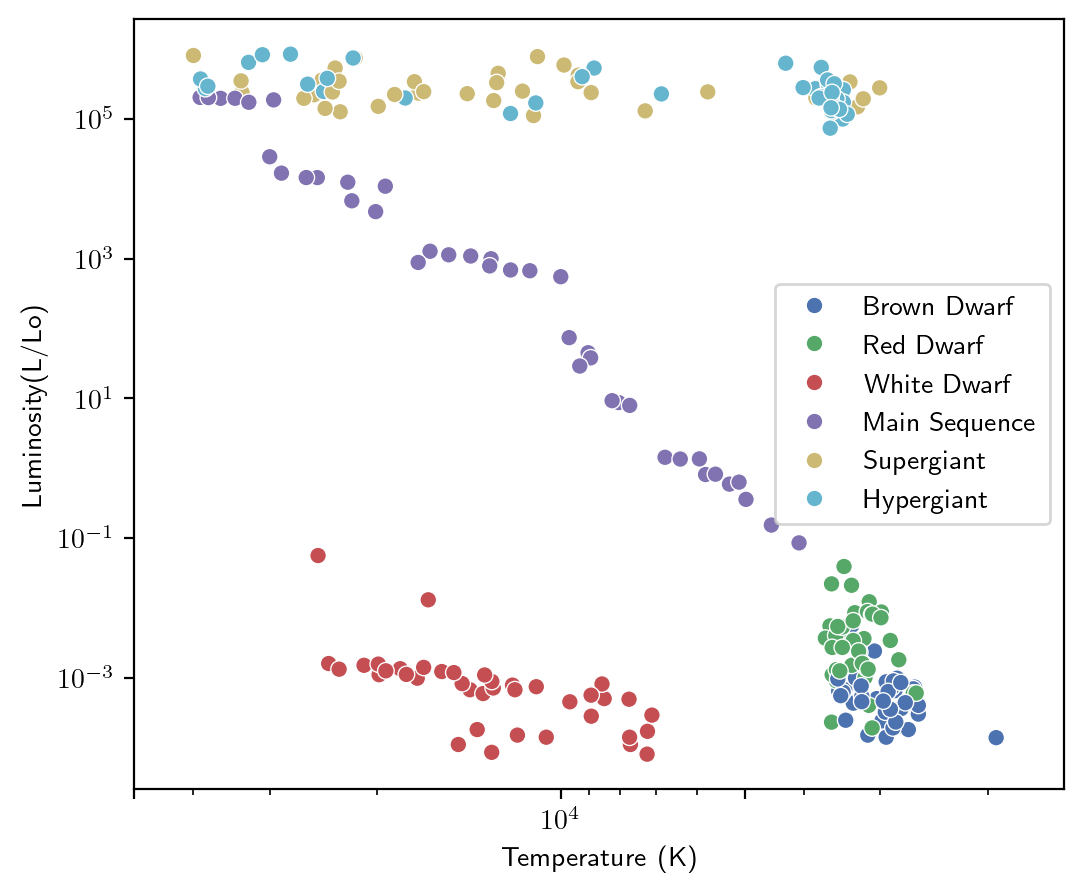

In [6]:
fig = plt.figure(figsize=(6, 5))
sns.scatterplot(df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels)

plt.loglog()
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.show()

### Check for outliers and NaNs

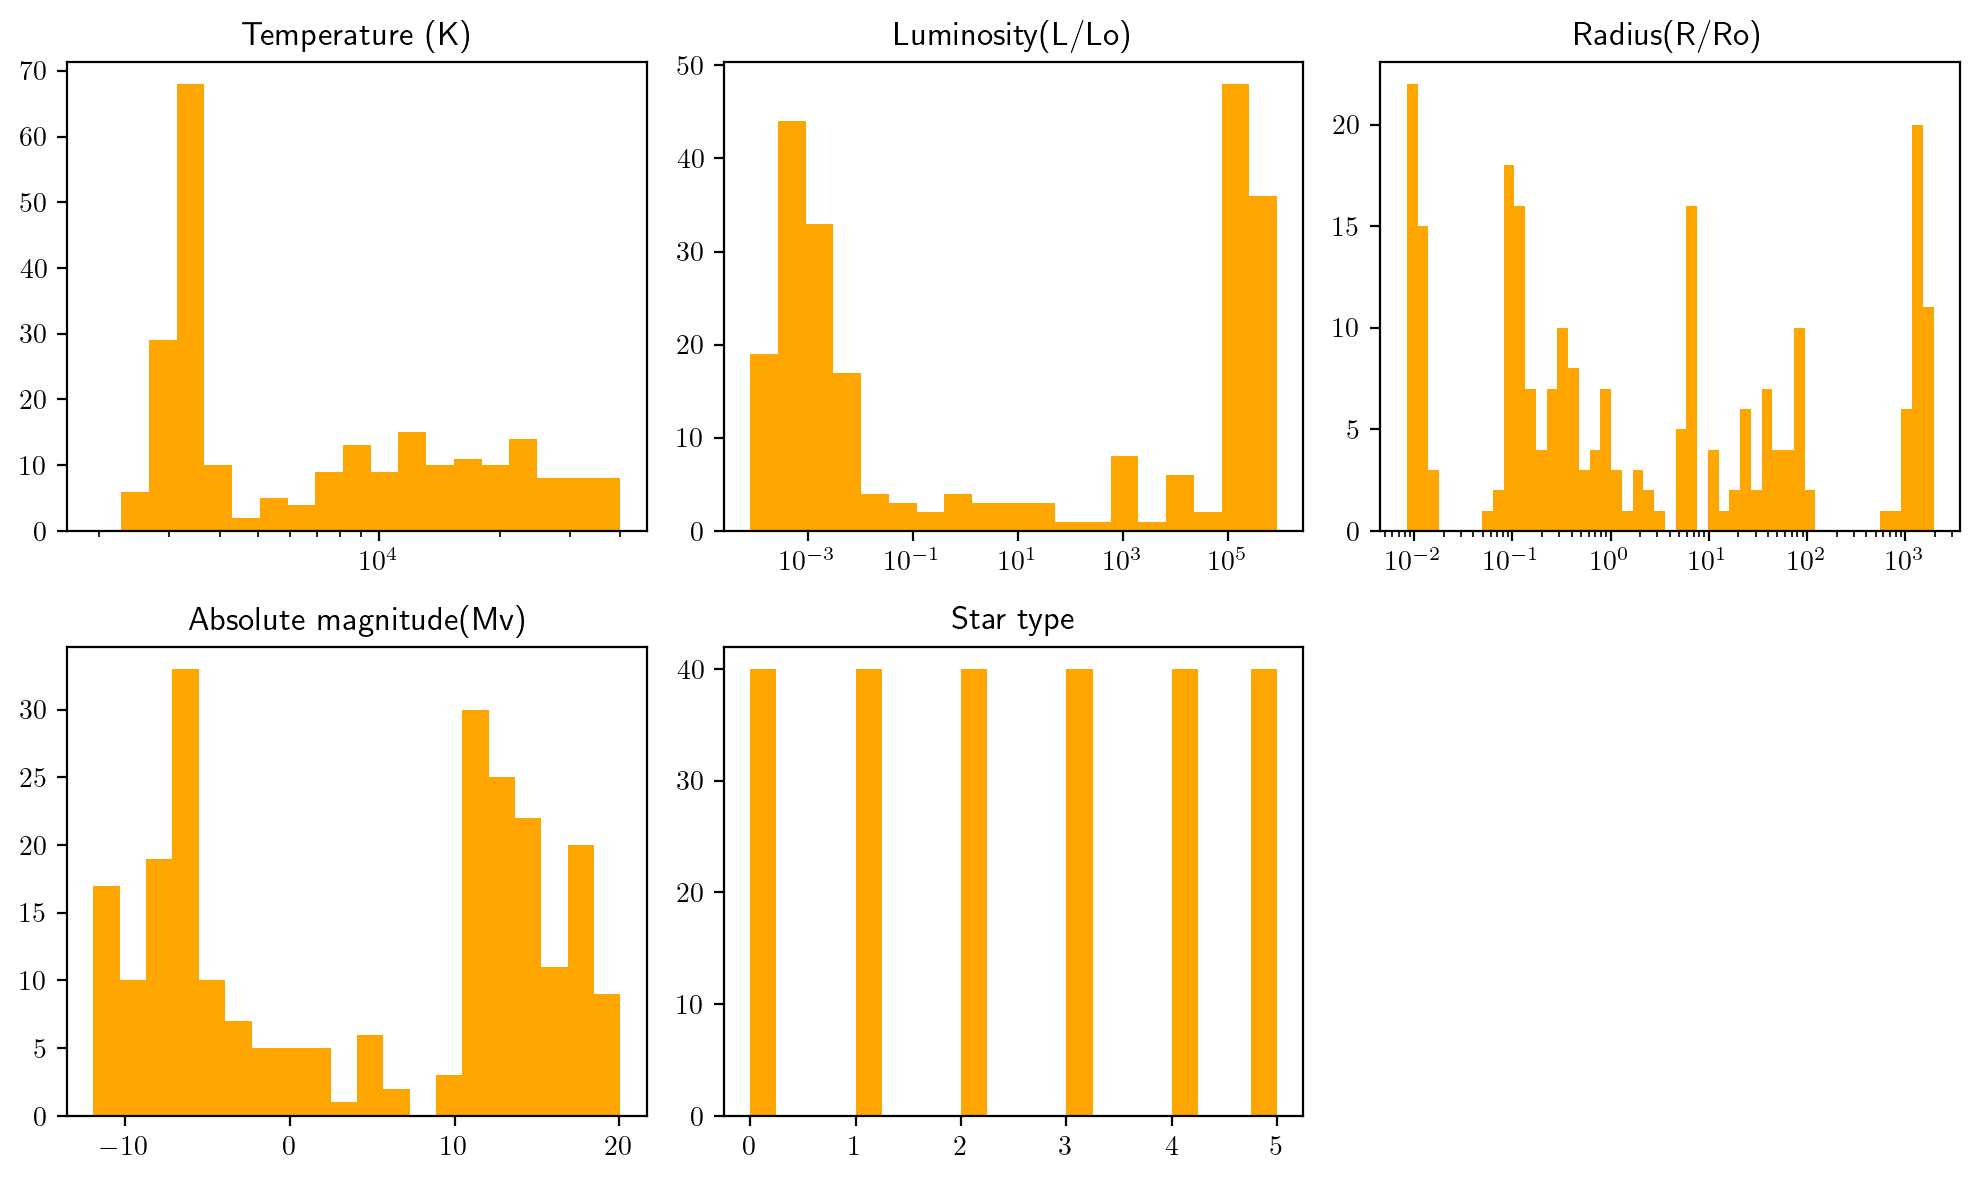

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(10, 6))  # Cambiato layout a 2x3 e aumentato la dimensione verticale

axs[0, 0].hist(df_stars['Temperature (K)'], bins=np.logspace(np.log10(df_stars['Temperature (K)'].min()), 
                                                             np.log10(df_stars['Temperature (K)'].max()), 20), color='orange')
axs[0, 0].set_xscale('log')  # Imposta scala logaritmica sull'asse x
axs[0, 0].set_title('Temperature (K)')
# print(len(df_stars['Temperature (K)']))

axs[0, 1].hist(df_stars['Luminosity(L/Lo)'], bins=np.logspace(np.log10(df_stars['Luminosity(L/Lo)'].min()), 
                                                              np.log10(df_stars['Luminosity(L/Lo)'].max()), 20), color='orange')
axs[0, 1].set_xscale('log')  # Imposta scala logaritmica sull'asse x
axs[0, 1].set_title('Luminosity(L/Lo)')
# print(len(df_stars['Luminosity(L/Lo)']))

axs[0, 2].hist(df_stars['Radius(R/Ro)'], bins=np.logspace(np.log10(df_stars['Radius(R/Ro)'].min()), 
                                                          np.log10(df_stars['Radius(R/Ro)'].max()), 50), color='orange')
axs[0, 2].set_xscale('log')  # Imposta scala logaritmica sull'asse x
axs[0, 2].set_title('Radius(R/Ro)')
# print(len(df_stars['Radius(R/Ro)']))

axs[1, 0].hist(df_stars['Absolute magnitude(Mv)'], 20, color='orange')
axs[1, 0].set_title('Absolute magnitude(Mv)')
# print(len(df_stars['Absolute magnitude(Mv)']))

axs[1, 1].hist(df_stars['Star type'], 20, color='orange')
axs[1, 1].set_title('Star type')
# print(len(df_stars['Star type']))

axs[1, 2].axis('off')  # Lascia uno spazio vuoto al posto del sesto grafico

plt.tight_layout()  # Aggiunto per gestire meglio lo spazio tra i grafici
plt.show()

It seems that no outliers and NaN are present. I can proceed.

### Dimensionality reduction: PCA

In [8]:
X = np.array( df_stars[["Temperature (K)", "Luminosity(L/Lo)", "Radius(R/Ro)", "Absolute magnitude(Mv)"]] )

In [9]:
pca = PCA(n_components=2)
proj_X = pca.fit_transform(X) 

eigenvalues = pca.transform(X) 
mean = pca.mean_
eigenvectors = pca.components_ 

print(eigenvalues.shape)
print(eigenvectors.shape)

(240, 2)
(2, 4)


In [10]:
evals = pca.explained_variance_ratio_ 
print('Expained fractional variance of data encapsulated in the eigenvalues: ' + str(evals))

Expained fractional variance of data encapsulated in the eigenvalues: [0.99760631 0.0023879 ]


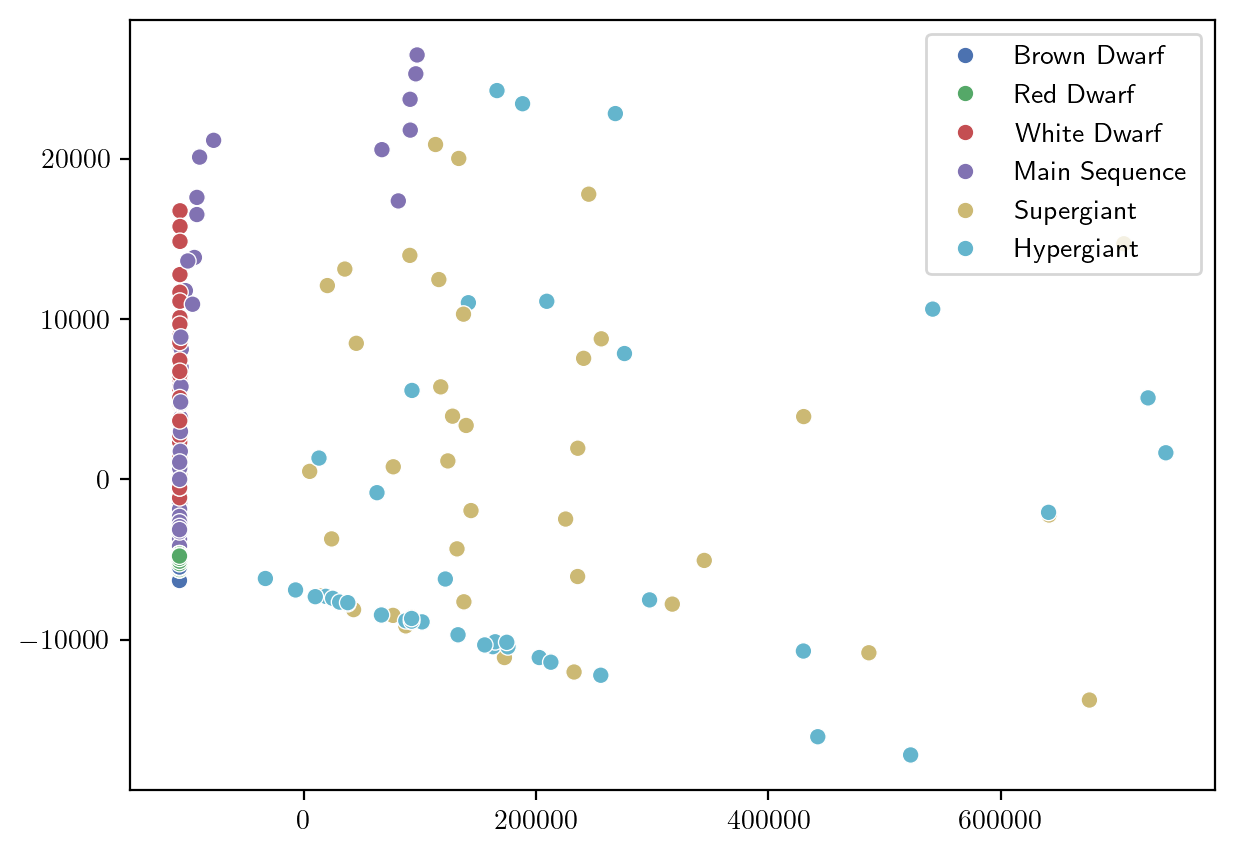

In [11]:
fig = plt.figure(figsize=(7, 5))
sns.scatterplot(x=proj_X[:,0], y=proj_X[:,1], hue=labels)

plt.show()

I'm not able to visualize the data easily. I have to try to rescale them before applying PCA (as suggested).

But before, let's quickly check the reconstruction 

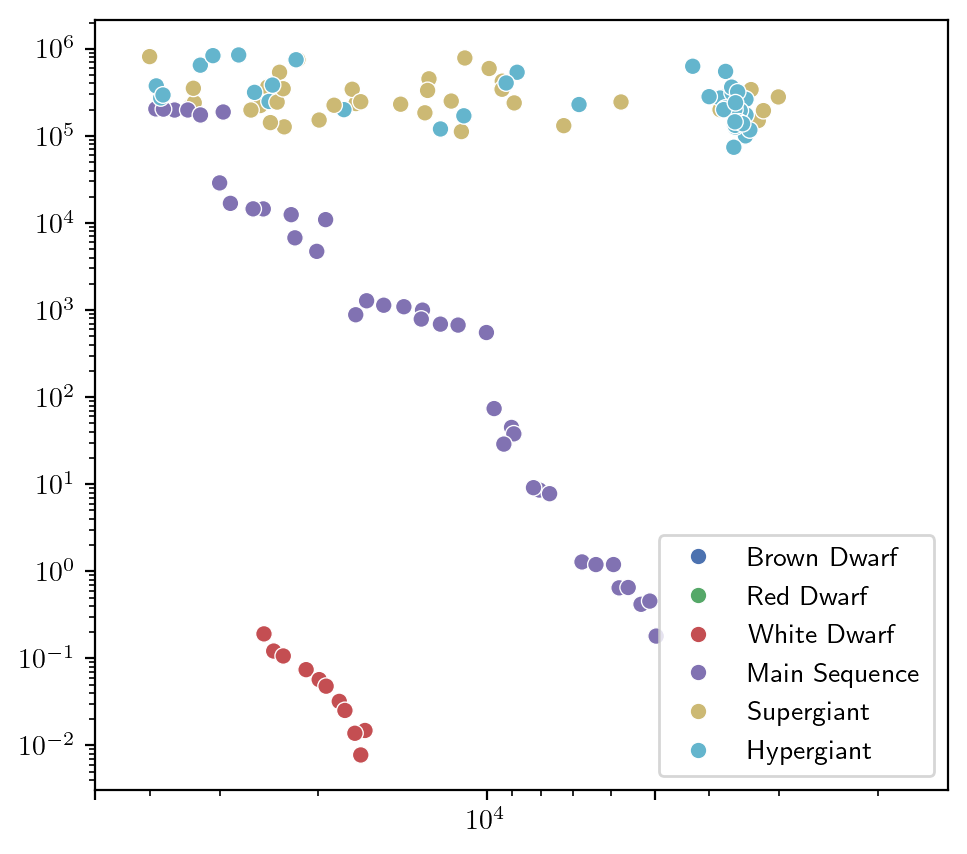

In [12]:
# Reconstruction of object1
# Xreconstruct[0] = mean + eigenvectors*eigenvalues[0]

Xreconstruct = mean + np.dot(eigenvalues, eigenvectors) 

fig = plt.figure(figsize=(5.5, 5))
sns.scatterplot(x=Xreconstruct[:,0], y=Xreconstruct[:,1], hue=labels)

plt.loglog()
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.show()

It seems to do an acceptable job for now.

### Rescale the data and THEN apply PCA

Rescale the data

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

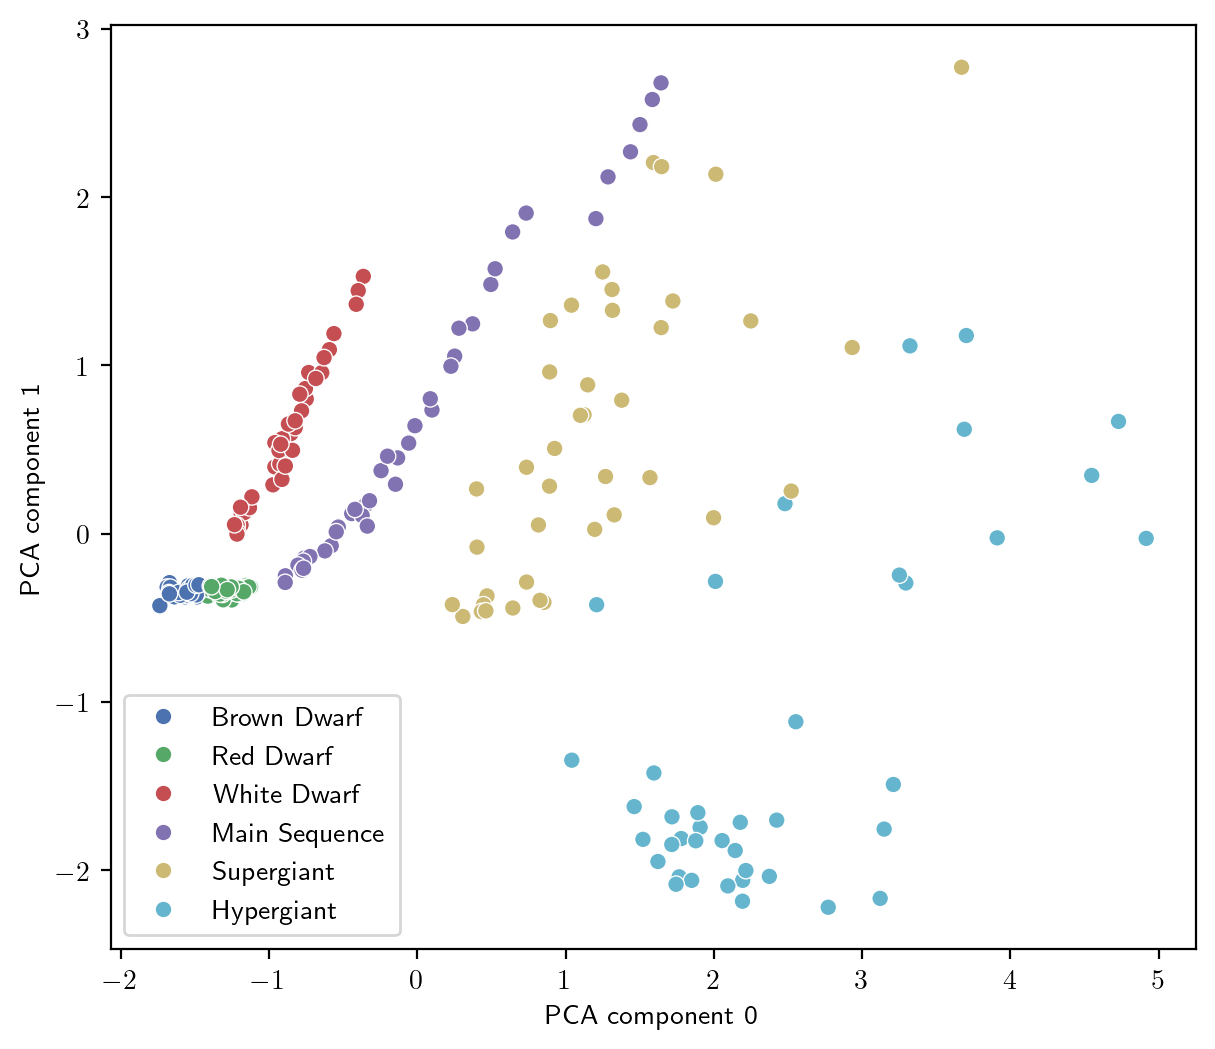

In [14]:
pca = PCA(n_components=2)
proj_X = pca.fit_transform(X_scaled) 

eigenvalues = pca.transform(X_scaled) 
mean = pca.mean_
eigenvectors = pca.components_ 

#print(eigenvalues.shape)
#print(eigenvectors.shape)

fig = plt.figure(figsize=(7, 6))
sns.scatterplot(x=proj_X[:,0], y=proj_X[:,1], hue=labels)
plt.xlabel("PCA component 0")
plt.ylabel("PCA component 1")
plt.show()

In [15]:
evals = pca.explained_variance_ratio_ 
print('Expained fractional variance of data encapsulated in the eigenvalues: ' + str(evals))

Expained fractional variance of data encapsulated in the eigenvalues: [0.60357391 0.23500784]


In [16]:
cumul_var_ratio = 0
for i, var_ratio in enumerate(evals):
    cumul_var_ratio += var_ratio
    print(f"Component {i} explains {100*var_ratio:.1f}% of the variance (cumulative = {100*cumul_var_ratio:.1f})")

Component 0 explains 60.4% of the variance (cumulative = 60.4)
Component 1 explains 23.5% of the variance (cumulative = 83.9)


#### Increase the number of components and display them

In [17]:
n_components = 4
pca_m = PCA(n_components)
proj_X_m = pca_m.fit_transform(X_scaled) 

eigenvalues_m = pca_m.transform(X_scaled) 
mean_m = pca_m.mean_
eigenvectors_m = pca_m.components_ 

evals_m = pca_m.explained_variance_ratio_ 

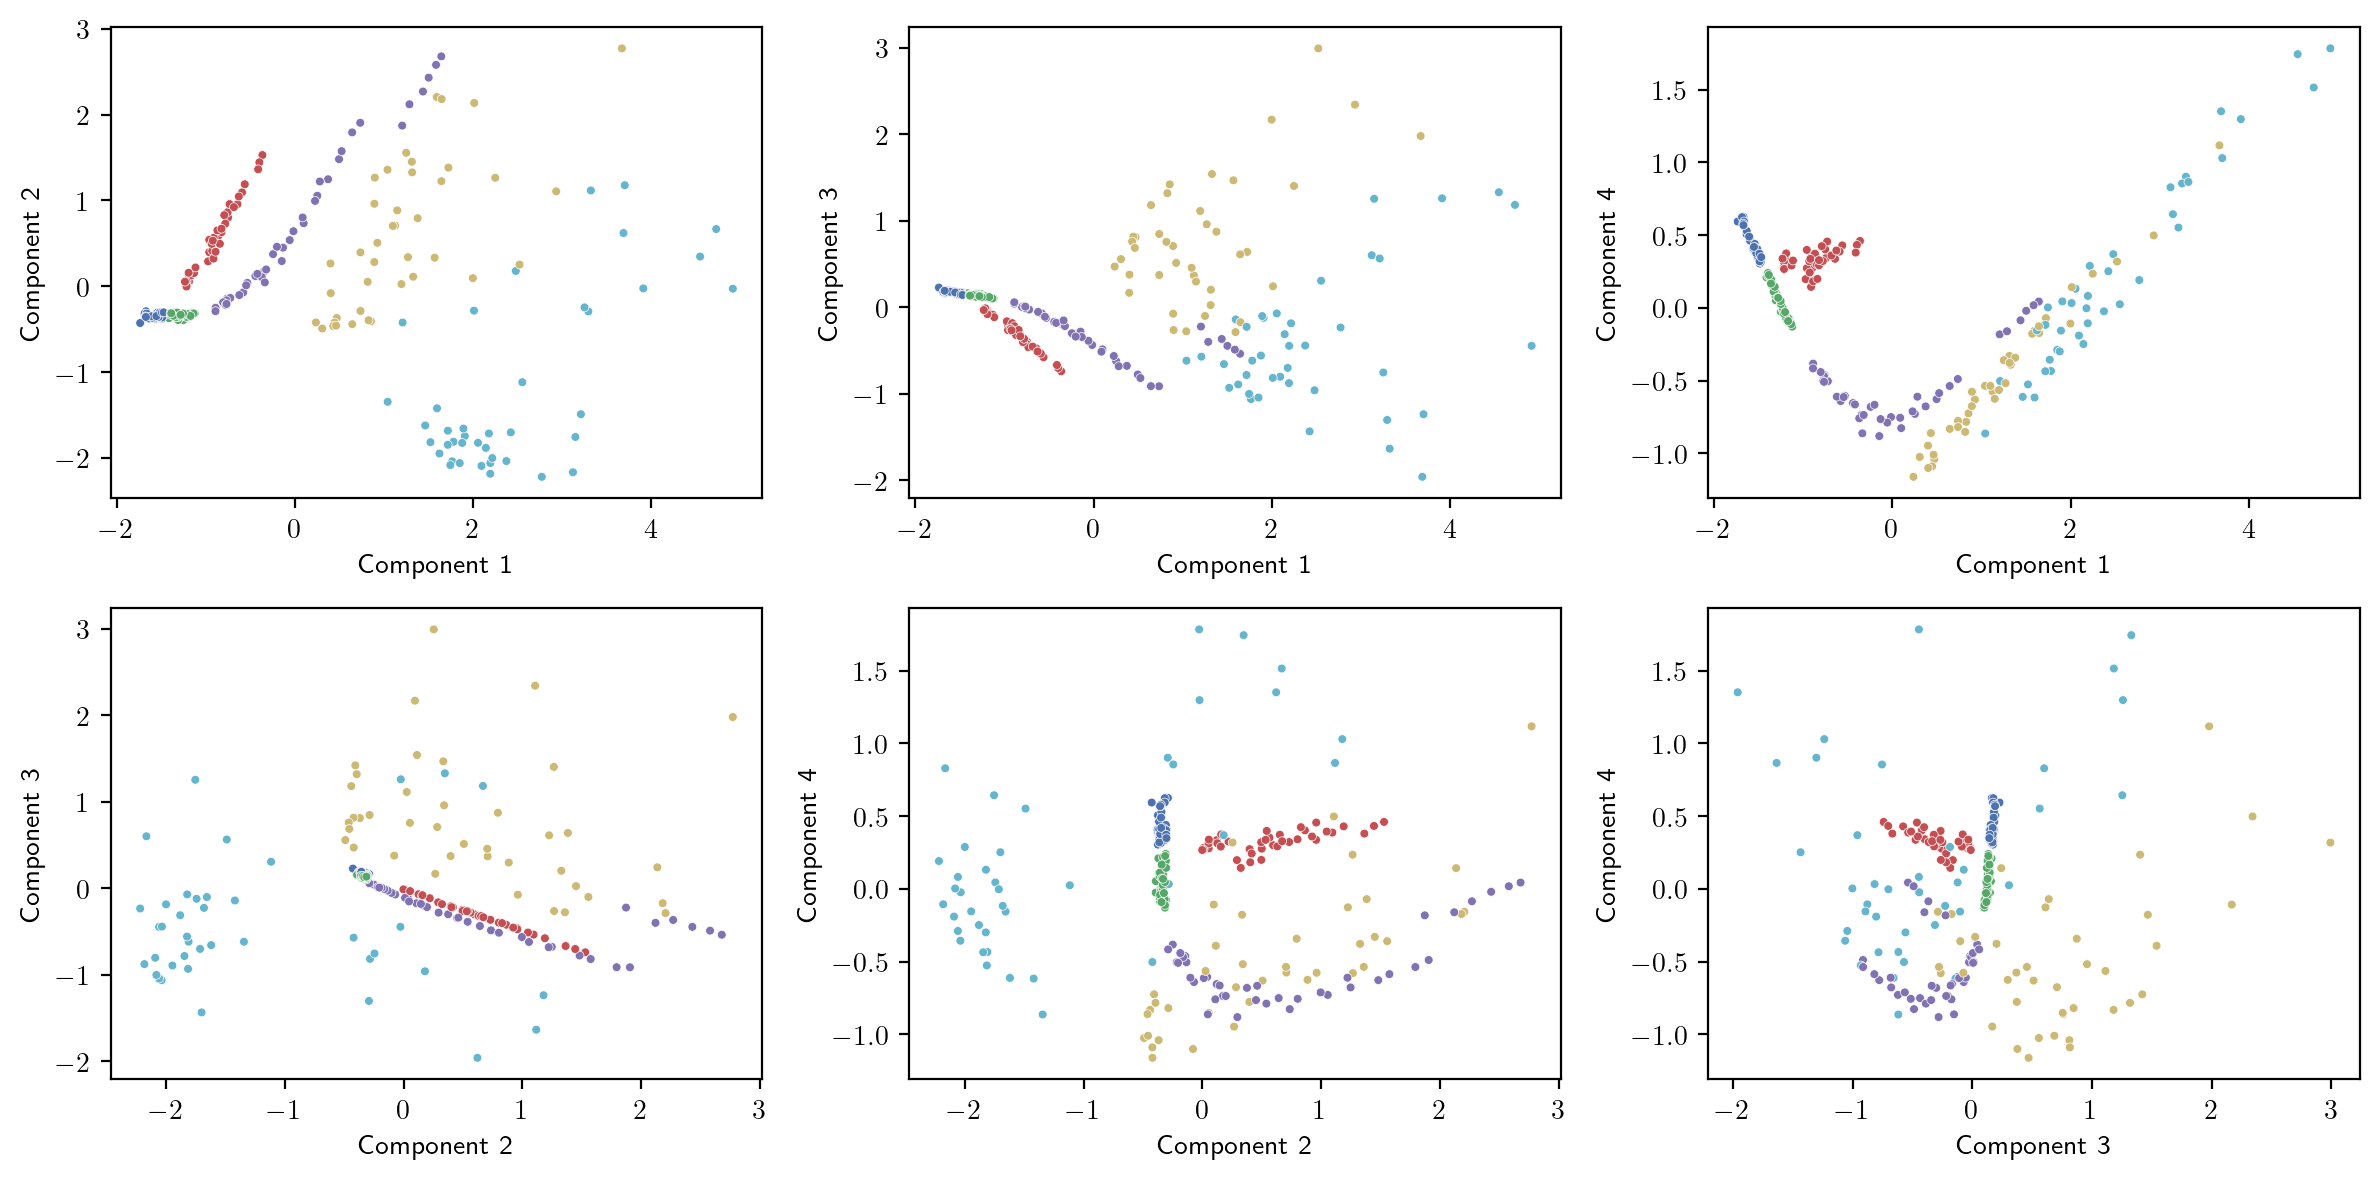

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()
idx = 0

for i in range(4):
    for j in range(i + 1, 4):
        sc = sns.scatterplot(x=proj_X_m[:, i], y=proj_X_m[:, j], hue=labels, s=10, ax=axes[idx], legend=False)
        
        axes[idx].set_xlabel(f'Component {i+1}')
        axes[idx].set_ylabel(f'Component {j+1}')
        
        idx += 1

plt.tight_layout()
plt.show()

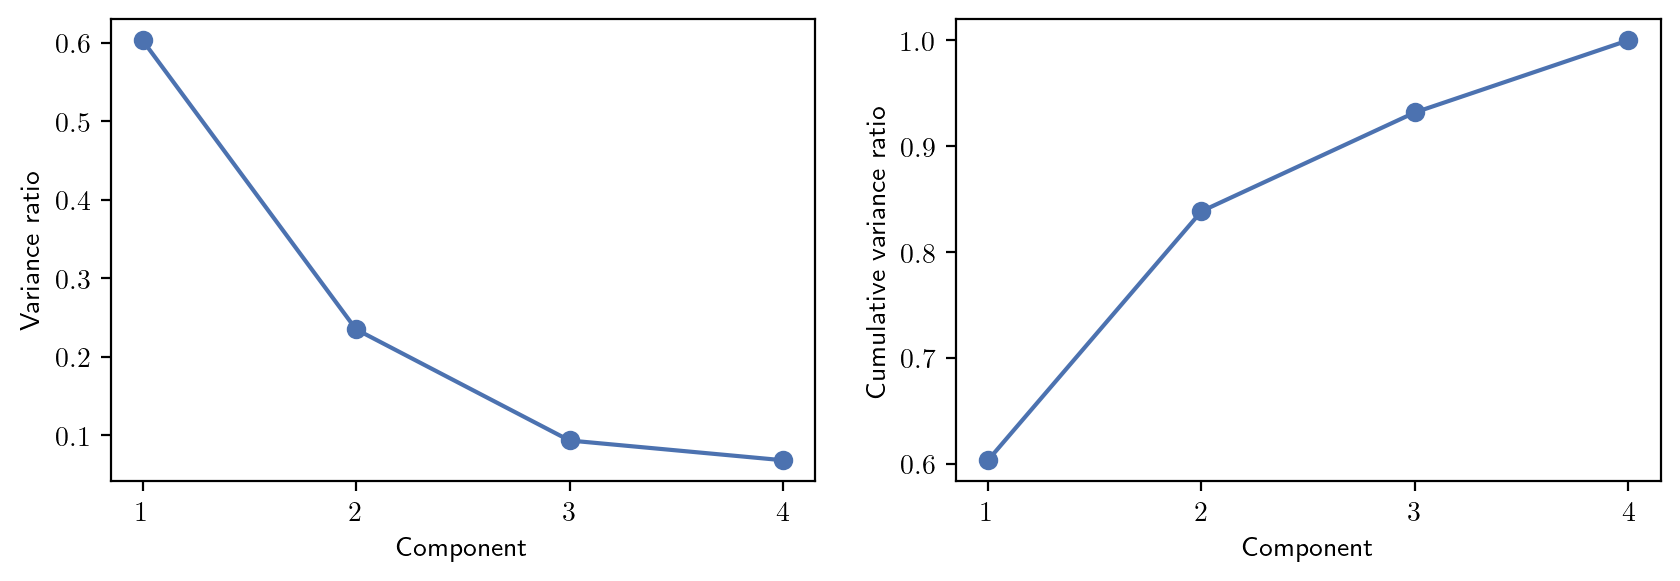

In [19]:
fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(121)

ax.plot(range(1, n_components+1), evals_m)
ax.scatter(range(1, n_components+1), evals_m)

ax.set_xlabel("Component")
ax.set_ylabel("Variance ratio")
ax.set_xticks(range(1, n_components+1))

ax = fig.add_subplot(122)

ax.plot(range(1, n_components+1), evals_m.cumsum())
ax.scatter(range(1, n_components+1), evals_m.cumsum())
ax.set_xticks(range(1, n_components+1))

ax.set_xlabel("Component")
ax.set_ylabel("Cumulative variance ratio")

plt.show()

### Supervised classification

In [20]:
le = LabelEncoder()
labels_num = le.fit_transform(df_stars['Star type'])

(X_train, X_test), (y_train, y_test) = split_samples(proj_X, labels_num, [0.70, 0.30], random_state=0)

In [21]:
# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42, n_estimators=50)

# Train the model
rf.fit(X_train, y_train)

# Evaluate the model
rf_train_accuracy = rf.score(X_train, y_train)
rf_test_accuracy = rf.score(X_test, y_test)

print(f"RandomForest Test Accuracy: {rf_test_accuracy:.4f}")

RandomForest Test Accuracy: 0.9722


In [22]:
y_pred = rf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[10,  0,  0,  0,  0,  0],
       [ 0, 12,  0,  0,  0,  0],
       [ 0,  0, 11,  0,  0,  0],
       [ 0,  0,  0, 13,  0,  0],
       [ 0,  0,  2,  0,  9,  0],
       [ 0,  0,  0,  0,  0, 15]])

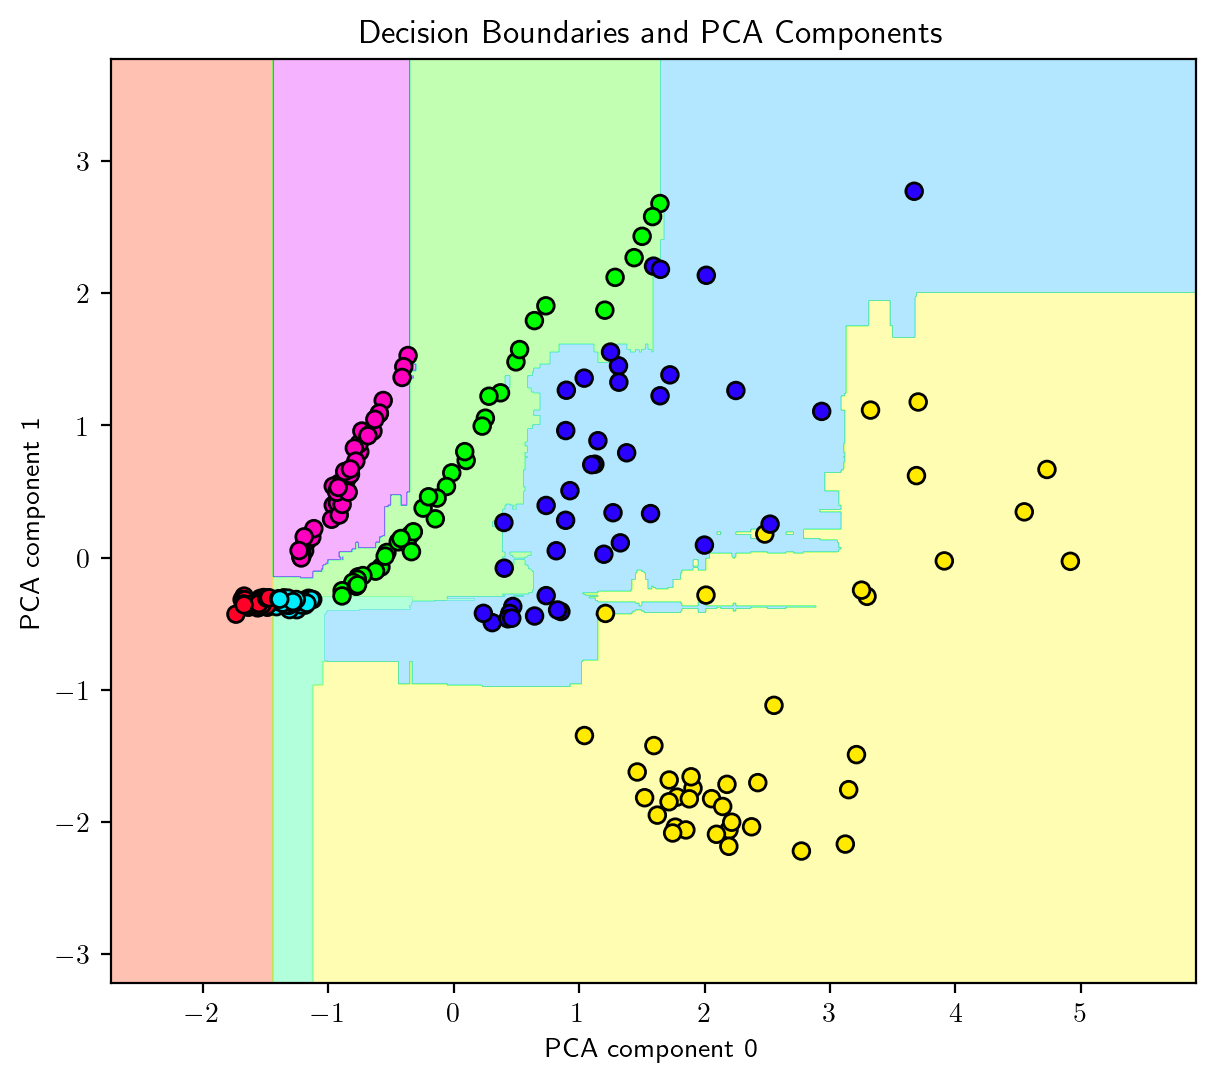

In [23]:
fig = plt.figure(figsize=(7, 6))

# Meshgrid to plot the contours
x_min, x_max = proj_X[:, 0].min() - 1, proj_X[:, 0].max() + 1
y_min, y_max = proj_X[:, 1].min() - 1, proj_X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

Xgrid = np.c_[xx.ravel(), yy.ravel()]  # matrix (N × 2), where each row is a point (x, y).

pred = rf.predict(Xgrid)
pred = pred.reshape(xx.shape)

# Plot 
plt.contourf(xx, yy, pred, alpha=0.3, cmap=plt.cm.gist_rainbow)
plt.scatter(proj_X[:, 0], proj_X[:, 1], c=labels_num, edgecolors='k', cmap=plt.cm.gist_rainbow, label=labels)
plt.xlabel("PCA component 0")
plt.ylabel("PCA component 1")
plt.title('Decision Boundaries and PCA Components')
#plt.legend()
plt.show()